<a href="https://colab.research.google.com/github/Davioliveira1305/CANA/blob/main/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Como criar uma rede neural

In [37]:
import torch
import numpy as np
from torch import nn

In [38]:
class LineNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # 1 neurônio
    self.layers = nn.Sequential(
        nn.Linear(1, 1)
    )

  # Como a rede computa(x é o dado que vai passar pelo neurônio)
  def forward(self, x):
    return self.layers(x)

# Como a treinar uma rede neural

## Preparando a infraestritura dos dados

In [39]:
# Bibliotecas utilizadas para a construção de um dataset
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [40]:
# Classe que constrói o DataSet
class AlgebraicDataset(Dataset):
  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, f(x)) for x in X]

  # Quantos dados eu tenho no DataSet
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [41]:
line = lambda x: 2 * x + 3
interval = (-10, 10)
train_nsamples = 1000
test_nsamples = 100

In [42]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = test_nsamples, shuffle=True)

## Hiperparâmetros de otimização

In [43]:
# Acesso a uma gpu Nvidia
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Tá rodando na {device}')

Tá rodando na cpu


In [44]:
model = LineNetwork().to(device)

In [45]:
# Função de perda
# Erro quadrático médio
loss_func = nn.MSELoss()
# Gradiente Descendente Estocástico
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3) # lr = taxa de aprendizado

In [46]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0
  for x, y in dataloader:
    x = x.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(x)
    loss = loss_func(pred, y)

    # Zera o gradiente
    optimizer.zero_grad()
    # Calcula o gradiente
    loss.backward()
    # Anda na direção que reduz a função de perda
    optimizer.step()

    # Loss é um tensor
    cumloss += loss.item()

  return cumloss/len(dataloader)

def teste(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0
  with torch.no_grad():
    for x, y in dataloader:
      x = x.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(x)
      loss = loss_func(pred, y)

      # Loss é um tensor
      cumloss += loss.item()

  return cumloss/len(dataloader)


## Treinando a rede de fato

In [47]:
# Pra visualizar
import matplotlib.pyplot as plt
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()

Época = 0, Erro de treinamento = 297.10125732421875


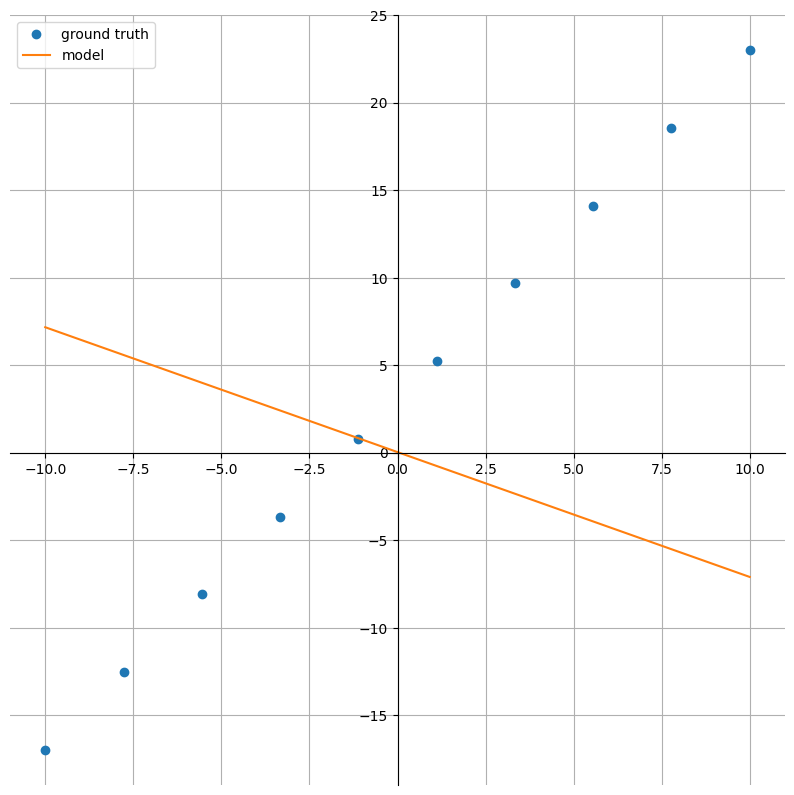

Época = 10, Erro de treinamento = 79.66642761230469


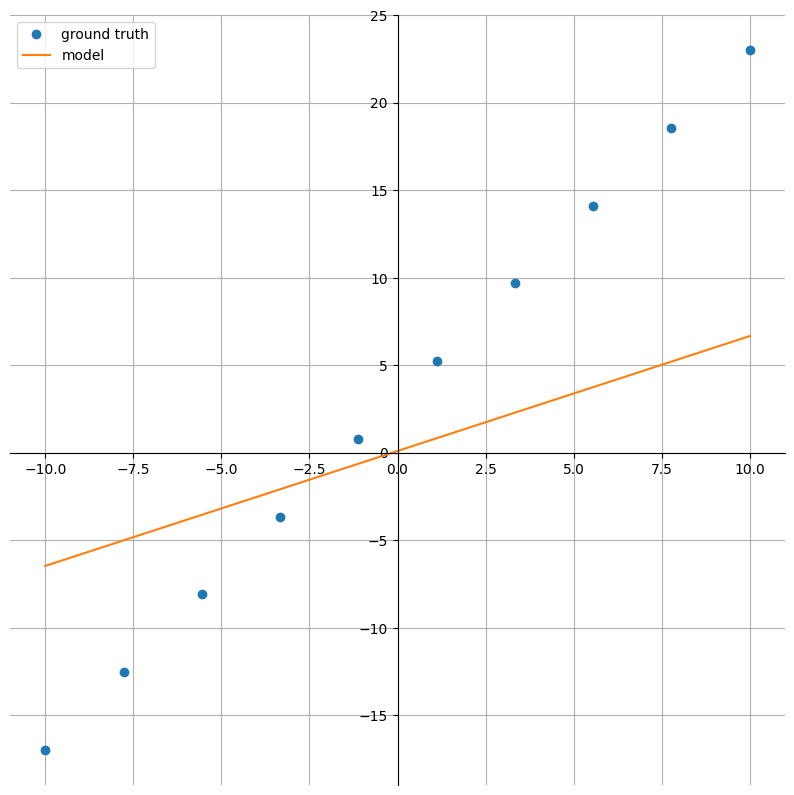

Época = 20, Erro de treinamento = 25.731016159057617


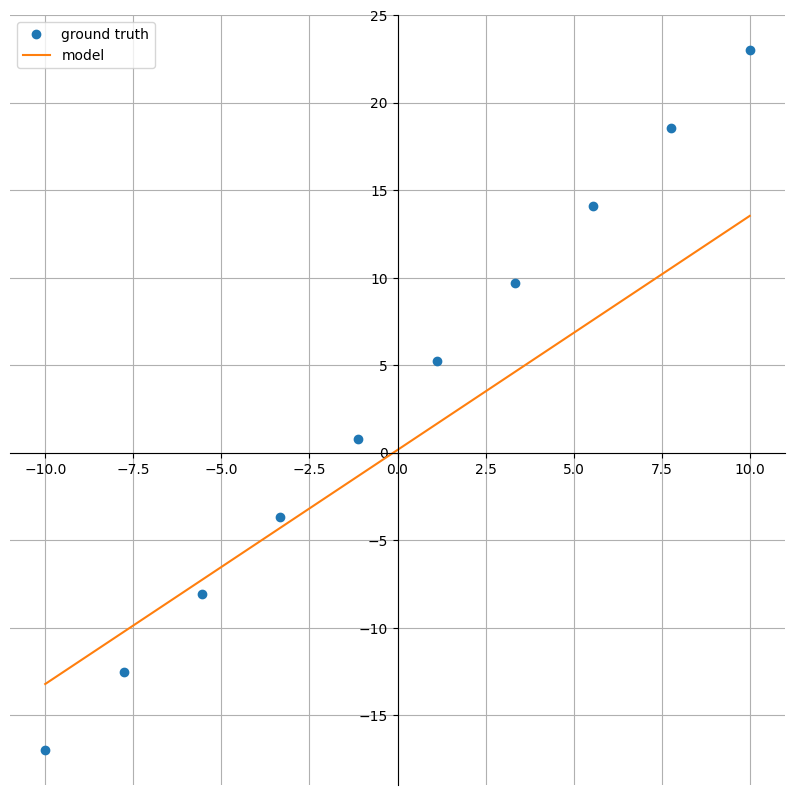

Época = 30, Erro de treinamento = 12.175793647766113


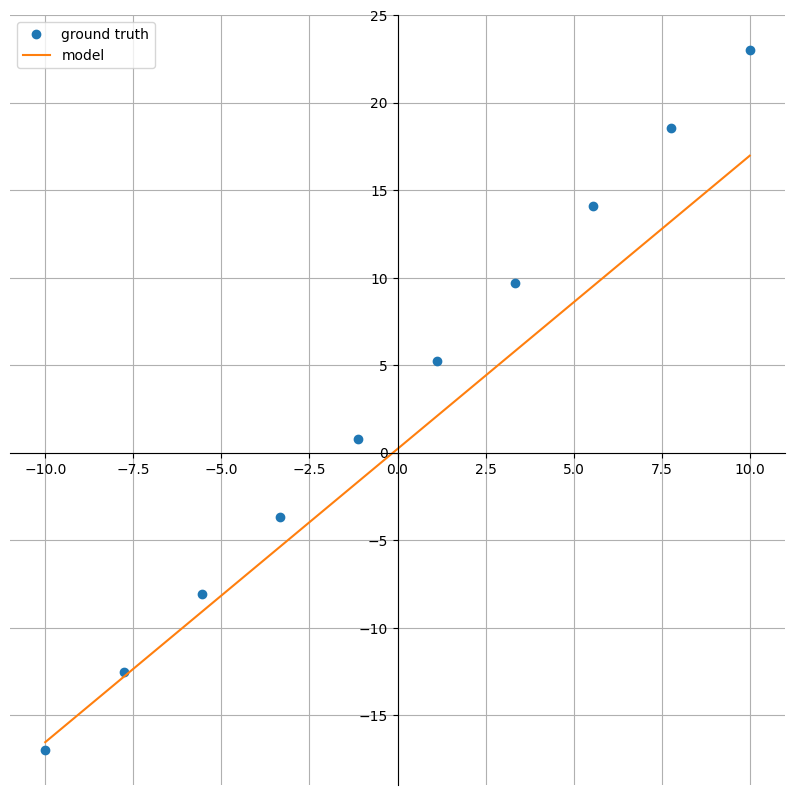

Época = 40, Erro de treinamento = 8.600373268127441


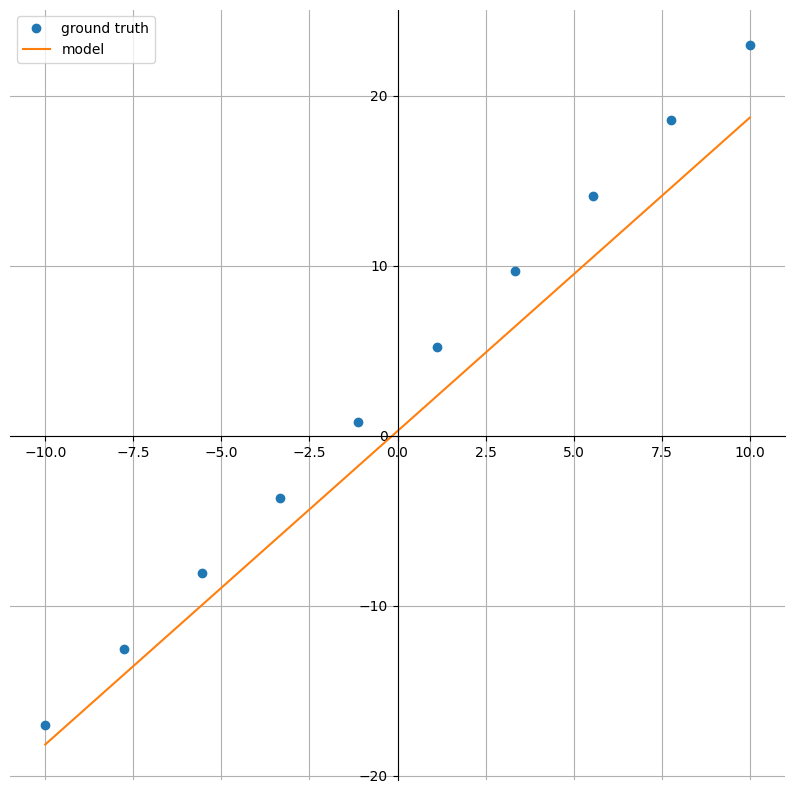

Época = 50, Erro de treinamento = 7.498082160949707


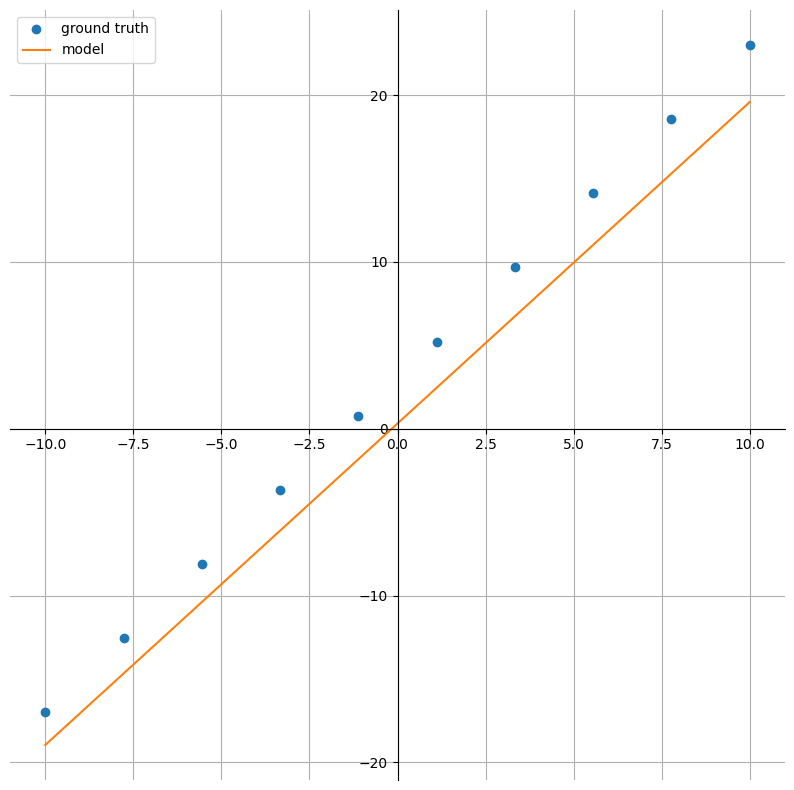

Época = 60, Erro de treinamento = 7.01505184173584


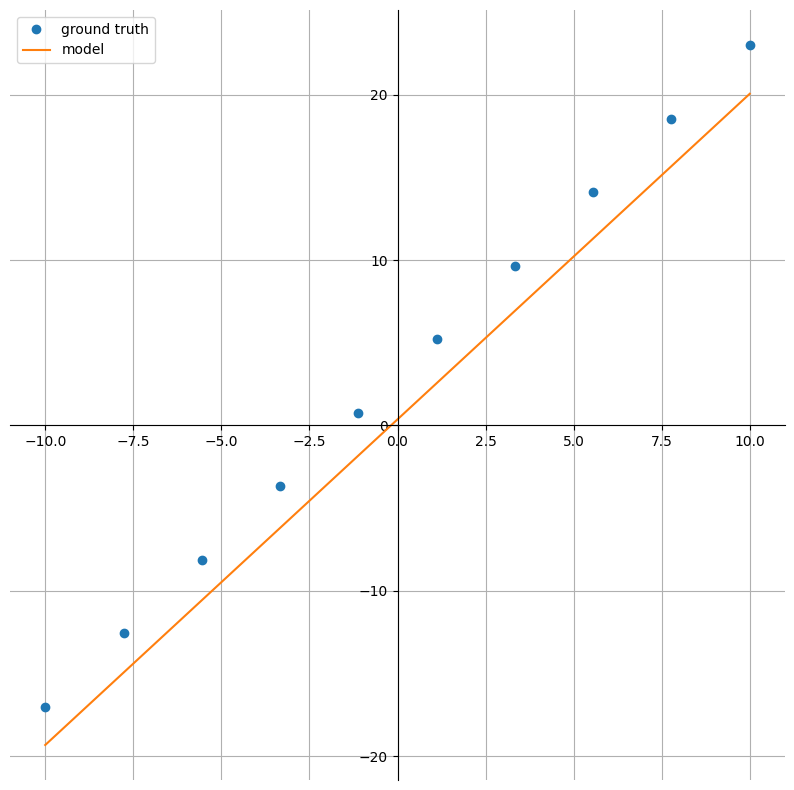

Época = 70, Erro de treinamento = 6.693198204040527


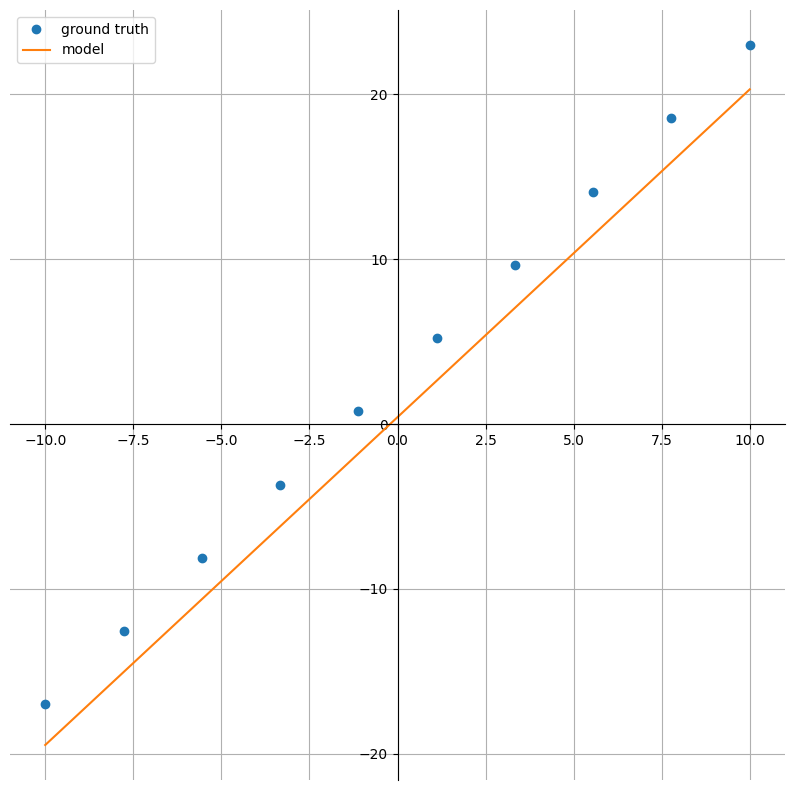

Época = 80, Erro de treinamento = 6.419091701507568


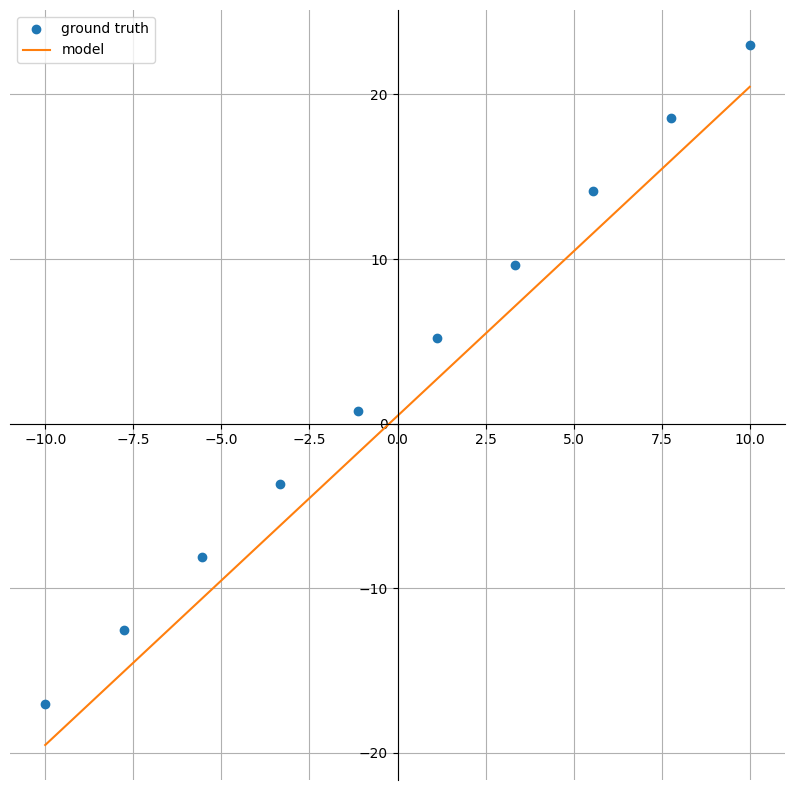

Época = 90, Erro de treinamento = 6.164407253265381


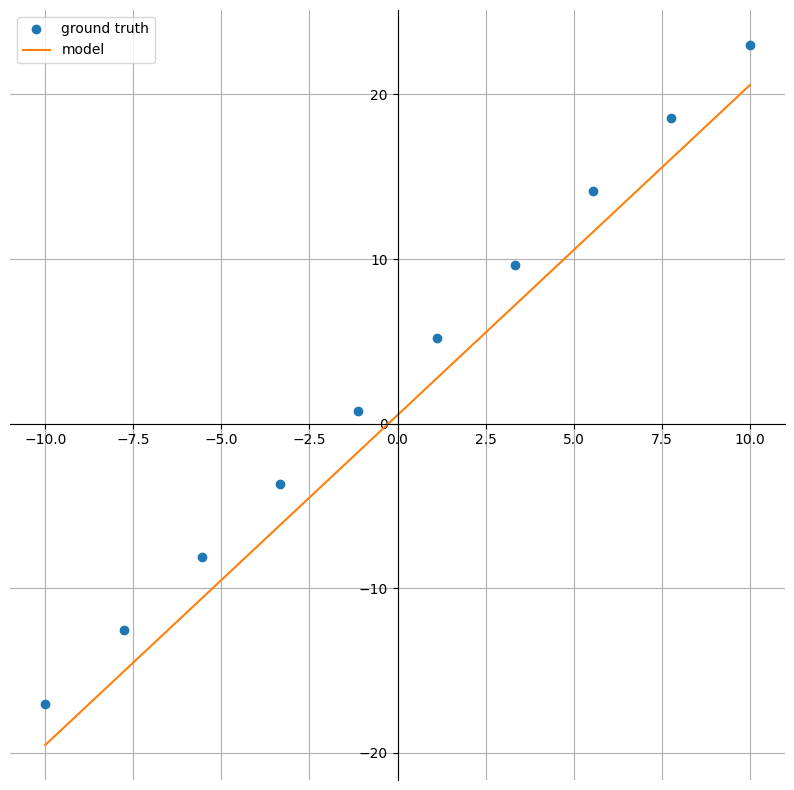

Época = 100, Erro de treinamento = 5.921858787536621


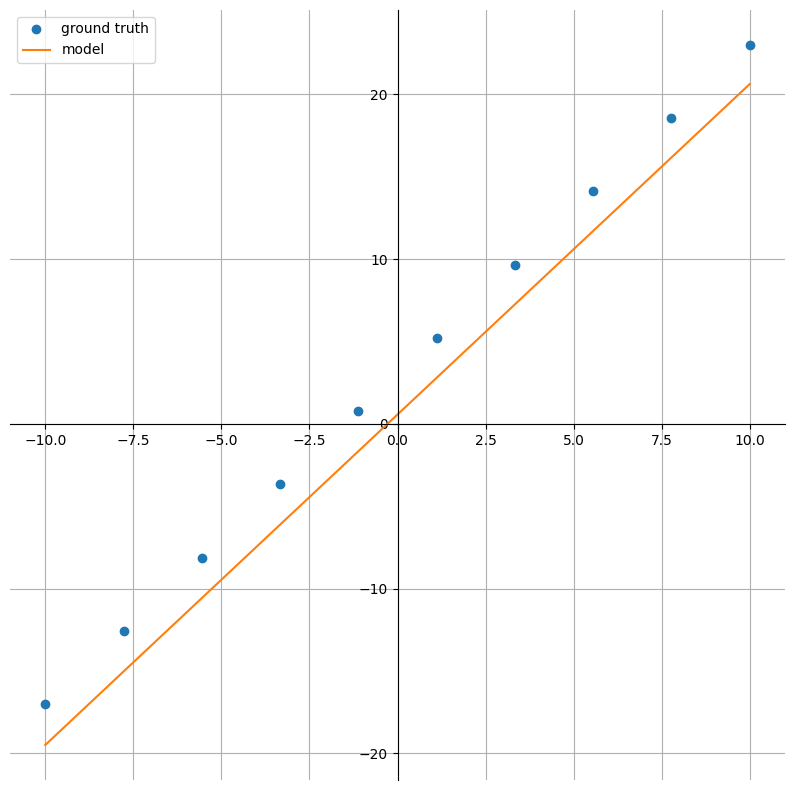

Erro do teste = 5.888210296630859


In [48]:
epochs = 101
for t in range(epochs):
  train_loss = train(model, train_dataloader, loss_func, optimizer)
  if t % 10 == 0:
    print(f'Época = {t}, Erro de treinamento = {train_loss}')
    plot_comparinson(line, model)

test_loss = teste(model, test_dataloader, loss_func)
print(f'Erro do teste = {test_loss}')